## This program is to build up the CCAE+RUL research step by step ##



In [1]:
# import used functioons 
#  import tools 
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Conv1D, Dense, concatenate, RepeatVector, MaxPooling1D, Activation ,UpSampling1D, Conv1DTranspose, Concatenate
from tensorflow.keras.utils import plot_model
import numpy as np 
import pandas as pd
from openpyxl import Workbook
import matplotlib.pyplot as plt
import os
import sys
import csv
import time
from IPython import embed

from IPython import embed

from rul_features.rul_data_read import read_rul_data

from test_algs.CCAE_ntu_rul import get_initial_files_datalist, CCAE_train
from test_algs.CCAE_ntu_rul import CCAE_model_application, CCAE_model_build_train

* First step: check the file status *

In [2]:
# 開啟互動模式
%matplotlib widget

train_file_list=[]

# Data set folder 
NTU_dataset_path = r'D:\OneDrive\RUL HI Reasearch Result\Data_sets\NTU_RUL_v2_data\Acc_life_test_data\Organized_Data'

# 測試階段只引入 1800rpm的資料

# -----------------------10psi data--------------------

collect_setting = r"Load_Free\Speed_1800\Pressure_10psi"  
train_file_list.append(os.path.join(NTU_dataset_path, collect_setting, r"0312_V1800_10P_FREE0"))
train_file_list.append(os.path.join(NTU_dataset_path, collect_setting, r"0313_V1800_10P_FREE1"))
train_file_list.append(os.path.join(NTU_dataset_path, collect_setting, r"0314_V1800_10P_FREE2"))

collect_setting = r"Load_1V\Speed_1800\Pressure_10psi"
train_file_list.append(os.path.join(NTU_dataset_path, collect_setting, r"10kg_1V_1800rpm_1"))
train_file_list.append(os.path.join(NTU_dataset_path, collect_setting, r"15kg_1V_1800rpm_1"))
train_file_list.append(os.path.join(NTU_dataset_path, collect_setting, r"15kg_1V_1800rpm_2"))

collect_setting = r"Load_2V\Speed_1800\Pressure_10psi"
train_file_list.append(os.path.join(NTU_dataset_path, collect_setting, r"0509_V1800_10P_2_1"))

# -----------------------5psi data--------------------

collect_setting = r"Load_1V\Speed_1800\Pressure_5psi"
# train_file_list.appeng(os.path.join(NTU_dataset_path, collect_setting, r"5psi_1V_1_3min"))
train_file_list.append(os.path.join(NTU_dataset_path, collect_setting, r"06kg_1V_1800rpm_2"))

collect_setting= r"Load_0V\Speed_1800\Pressure_5psi"
train_file_list.append(os.path.join(NTU_dataset_path, collect_setting, r"0313_V1800_5P_FREE2"))

collect_setting= r"Load_2V\Speed_1800\Pressure_5psi"
train_file_list.append(os.path.join(NTU_dataset_path, collect_setting, r"0402_V1800_5P_2_1"))

# 確認 train_file_list 中的所有路徑是否存在
for path in train_file_list:
    if not os.path.exists(path):
        print(f"檔案不存在: {path}")
    else:
        print(f"檔案存在: {path}")





檔案存在: D:\OneDrive\RUL HI Reasearch Result\Data_sets\NTU_RUL_v2_data\Acc_life_test_data\Organized_Data\Load_Free\Speed_1800\Pressure_10psi\0312_V1800_10P_FREE0
檔案存在: D:\OneDrive\RUL HI Reasearch Result\Data_sets\NTU_RUL_v2_data\Acc_life_test_data\Organized_Data\Load_Free\Speed_1800\Pressure_10psi\0313_V1800_10P_FREE1
檔案存在: D:\OneDrive\RUL HI Reasearch Result\Data_sets\NTU_RUL_v2_data\Acc_life_test_data\Organized_Data\Load_Free\Speed_1800\Pressure_10psi\0314_V1800_10P_FREE2
檔案存在: D:\OneDrive\RUL HI Reasearch Result\Data_sets\NTU_RUL_v2_data\Acc_life_test_data\Organized_Data\Load_1V\Speed_1800\Pressure_10psi\10kg_1V_1800rpm_1
檔案存在: D:\OneDrive\RUL HI Reasearch Result\Data_sets\NTU_RUL_v2_data\Acc_life_test_data\Organized_Data\Load_1V\Speed_1800\Pressure_10psi\15kg_1V_1800rpm_1
檔案存在: D:\OneDrive\RUL HI Reasearch Result\Data_sets\NTU_RUL_v2_data\Acc_life_test_data\Organized_Data\Load_1V\Speed_1800\Pressure_10psi\15kg_1V_1800rpm_2
檔案存在: D:\OneDrive\RUL HI Reasearch Result\Data_sets\NTU_RUL_v

## Model build up ##
I2 in I2 out

Model CCAE_V2_in_I2_out_torque_condition.keras exists, loading the model.
Model CCAE_V2_in_I2_out_torque_condition.keras retraining is required.


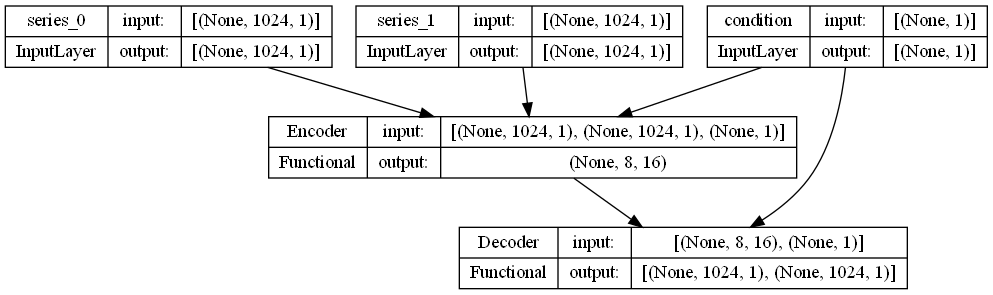

In [3]:
from datetime import datetime
import json


def build_ccae_model(input_dim_list, sequence_length, condition_dim, model_folder_path, model_name):
            """
            Build and save a CCAE model.
            """
            inputs = []
            condition_input = Input(shape=(condition_dim,), name='condition')
            repeated_condition = RepeatVector(sequence_length, name='repeated_condition')(condition_input)

            for idx, input_dim in enumerate(input_dim_list):
                input_layer = Input(shape=(sequence_length, input_dim), name=f'series_{idx}')
                inputs.append(input_layer)

            encoder_input = Concatenate(axis=-1, name='full_encoder_input')(inputs + [repeated_condition])

            x = Conv1D(filters=64, kernel_size=64, strides=16, padding='same')(encoder_input)
            x = MaxPooling1D(pool_size=2)(x)
            x = Activation('relu')(x)

            x = Conv1D(filters=32, kernel_size=3, padding='same')(x)
            x = MaxPooling1D(pool_size=2)(x)
            x = Activation('relu')(x)

            x = Conv1D(filters=16, kernel_size=3, padding='same')(x)
            x = MaxPooling1D(pool_size=2)(x)
            encoded = Activation('relu')(x)

            encoder_model = Model(inputs=inputs + [condition_input], outputs=encoded, name='Encoder')

            decoder_input = Input(shape=(encoder_model.output_shape[1], encoder_model.output_shape[2]), name='encoder_output')
            decoder_condition_input = Input(shape=(condition_dim,), name='decoder_condition')
            repeated_decoder_condition = RepeatVector(encoded.shape[1])(decoder_condition_input)
            decoder_merge_input = concatenate([decoder_input, repeated_decoder_condition], name='merged_decoder_input')

            x = Conv1DTranspose(filters=16, kernel_size=3, padding='same')(decoder_merge_input)
            x = UpSampling1D(2)(x)
            x = Activation('relu')(x)

            x = Conv1DTranspose(filters=32, kernel_size=3, padding='same')(x)
            x = UpSampling1D(2)(x)
            x = Activation('relu')(x)

            x = Conv1DTranspose(filters=64, kernel_size=64, strides=16, padding='same')(x)
            x = UpSampling1D(2)(x)
            x = Activation('tanh')(x)

            output_list = [Dense(dim, activation='linear', name=f'output_{idx}')(x) for idx, dim in enumerate(input_dim_list)]
            decoder_model = Model(inputs=[decoder_input, decoder_condition_input], outputs=output_list, name='Decoder')

            full_encoder_inputs = inputs + [condition_input]
            encoded = encoder_model(full_encoder_inputs)
            decoder_outputs = decoder_model([encoded, condition_input])
            
            # 儲存模型 
            model = Model(inputs=full_encoder_inputs, outputs=decoder_outputs, name=f'CCAE_model{encoder_input.shape[2]-1}_in_{len(output_list)}_out')
            model.save(os.path.join(model_folder_path,"models", model_name))
            
            # 儲存模型 metadata
            metadata = {
                "model_name": model_name,
                "input_dim_list": input_dim_list,
                "sequence_length": sequence_length,
                "condition_dim": condition_dim,
                "created_at": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
                "trained": False,
                "train_date": None,
            }
            with open(os.path.join(model_folder_path,"model_inform", model_name.replace('.keras', '_metadata.json')), "w", encoding="utf-8") as f:
                json.dump(metadata, f, ensure_ascii=False, indent=4)
            
            return model

# 根據模型種類設定 input 和 output 的信號類型
network_input_signal_names=["Current alpha downsample", "Current beta downsample"] # for ccae training 
network_train_output_names=["Current alpha downsample", "Current beta downsample"] # for ccae apply output comparing 
input_dim_list = [1, 1]       

# model_type='I2_in_I2_out'
model_type='V2_in_I2_out'
# model_type='V2I2_in_V2I2_out'
if model_type == 'I2_in_I2_out':
    network_input_signal_names=["Current alpha downsample", "Current beta downsample"]
    network_train_output_names=["Current alpha downsample", "Current beta downsample"]
if model_type == 'V2_in_I2_out':
    network_input_signal_names=["Voltage alpha downsample", "Voltage beta downsample","Current alpha downsample", "Current beta downsample"]
    network_train_output_names=["Current alpha downsample", "Current beta downsample"]
if model_type == 'V2I2_in_V2I2_out':
    network_input_signal_names=["Voltage alpha downsample", "Voltage beta downsample", "Current alpha downsample", "Current beta downsample"]
    network_train_output_names=["Voltage alpha downsample", "Voltage beta downsample","Current alpha downsample", "Current beta downsample"]
    input_dim_list = [1, 1, 1, 1]   # quadra phase input, quadra phase output


condition_dim=1
sequence_length=1024
model_folder_path='NTU_rul_models'
model_name = f'CCAE_{model_type}_torque_condition.keras'
model_file_path = os.path.join(model_folder_path, "models", model_name)
# 是否重新訓練模型
model_retraining = False  
# model_retraining = True  


if os.path.exists(model_file_path) and model_retraining==False:
    # 如果模型已存在，則載入模型
    print(f"Model {model_name} exists, loading the model.")
    my_ccae_model_trained = load_model(model_file_path, compile=False)
    # 讀取前面儲存的 json metadata
    metadata_path = os.path.join(model_folder_path, "model_inform", model_name.replace('.keras', '_metadata.json'))
    with open(metadata_path, "r", encoding="utf-8") as f:
        model_metadata = json.load(f)
    
    # 確認模型是否訓練過
    if model_metadata.get("trained", False):
        print(f"Model {model_name} has been trained before, no need to retrain.")
        print(f"Model train date: {model_metadata['train_date']}")
        print(f"Model {model_name} loaded successfully.")
        
    else :

        print(f"Model {model_name} retraining is required.")
else :
          
        print(f"Model {model_name} is not  exist, building a new model.")
        my_ccae_model_trained = build_ccae_model(input_dim_list, sequence_length, condition_dim, model_folder_path, model_name)
        
# 畫出模型結構圖並存入指定資料夾
plot_model(my_ccae_model_trained, to_file=os.path.join(model_folder_path,"model_structure", model_name.replace('.keras', '.png')), show_shapes=True, show_layer_names=True)


** Step 2: train the ccae model **

取前10% 的資料作為訓練數據

In [4]:

from test_algs.CCAE_ntu_rul import data_augmentation
# use the first 10% data for CCAE training or filtering 

train_factor=0.1  # 訓練資料比例(前10%資料)
initial_files = []
initial_datalist=[]
train_input_signals=[]
train_output_signals=[]
Torque_conditions=[]

for file_path in train_file_list:
    if os.path.exists(file_path):

        # load and sort the files in path 
        files = [os.path.join(file_path, f) for f in os.listdir(file_path) if f.endswith(".parquet")] 
        files.sort(key=lambda f: int(os.path.splitext(os.path.basename(f))[0].split('_')[-1]))
        
        # Use only first 10% of files for training 
        num_files = max(int(len(files) * train_factor),1)
        
        #對每個測試資料夾取出訓練資料
        for i in range(num_files):
            # read the data
            df = read_rul_data(files[i])
            if len(df[network_input_signal_names[0]])<2000:
                print('incorrect data length, please check the file: \n', files[i])
                print('raw data length: ', len(df["Voltage alpha"]))
                continue
            # 合併測試資料至訓練維度 shape=(,4000,dim)
            temp_train_input_signals = []
            for input_name in network_input_signal_names:
            # normalization
                raw_data=np.array(df[input_name])
                mean = np.mean(raw_data)
                standard = np.std(raw_data)
                normalized = (raw_data - mean) / standard  # 轉成 (1024, 1)
                augmented_data= data_augmentation(normalized, time_steps=1024, window_size=10, cols=[0], random_seed=42)
                temp_train_input_signals.append(augmented_data) # normalization
                
                # 先做資料增強轉換至 (N*[(L-W)/1024+1], 1024, dim 維度)
                
            # 加入 train_input_s
            # ignals
            train_input_signals.append(np.stack(temp_train_input_signals, axis=2))
            # 直接將 df["Torque"] 擴展為 (temp_train_input_signals[0].shape[0], 1)
            torque_value = np.array(df["Torque"]).reshape(-1)
            torque_expanded = np.full(temp_train_input_signals[0].shape[0], torque_value[0])
            Torque_conditions.append(torque_expanded)
    else:
        print(f"File {file_path} does not exist.")
        
        
    
        
# 將所有訓練資料合併成一個大矩陣 (N_total, 1024, dim)
train_input_signals = np.concatenate(train_input_signals,axis=0)
Torque_conditions= np.concatenate(Torque_conditions,axis=0)
print(f"train_input_signals shape: {train_input_signals.shape}")
print(f"train_input_signals shape: {Torque_conditions.shape}")
        

Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalc

d:\Pycharm_conda_projects\NTU rul data analysis\rul_features\rul_data_read.py:164: RuntimeWarning: divide by zero encountered in scalar divide
  efficiency = Power_M / Power_E * 100


Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalc

KeyboardInterrupt: 

# 訓練模型 #

In [ ]:

def CCAE_train(kearas_model, model_type:str,  model_file_path=[],  input_data=[], label=1,  epochs=20, batch_size=10):
        
        # 可直接輸入模型或根據位置載入模型
        # 如果模型輸入位為模型路徑，則直接導入
        if isinstance(kearas_model, str):
            print("Loading model from path:", kearas_model)
            model_name= kearas_model
            kearas_model = load_model(kearas_model)
        else: 
            print("inout the model is keras model, not path")

        # 製作標籤
        Label = np.full(input_data.shape[0], label)
        # 先分割出80%的訓練數據和20%的驗證
        test_data_size = input_data.shape[0] * 2 // 10 # 測試數據是20%，額外算以確保各個label數量相同
        train_data, val_data, train_labels, val_labels = train_test_split(input_data, Label, test_size=test_data_size, random_state=38, shuffle=True, stratify=Label)
        
        
        # 根據訊號輸入維與類型，拆分成合適的輸入形狀 
        for i in range(input_data.shape[2]):
            if model_type == 'I2_in_I2_out':
                train_input_data=[train_data[:,:,i] for i in range(input_data.shape[2])]
                train_output_data=train_input_data.copy()
                val_input_data=[val_data[:,:,i] for i in range(input_data.shape[2])]
                val_output_data=val_input_data.copy()
            if model_type == 'V2_in_I2_out':
                train_input_data=[train_data[:,:,i] for i in range(0,2)]
                train_output_data=[train_data[:,:,i] for i in range(2,4)]
                val_input_data=[val_data[:,:,i] for i in range(0,2)]
                val_output_data=[val_data[:,:,i] for i in range(2,4)]
            if model_type == 'V2I2_in_V2I2_out':
                train_input_data=[train_data[:,:,i] for i in range(input_data.shape[2])]
                train_output_data=train_input_data.copy()
                val_input_data=[val_data[:,:,i] for i in range(input_data.shape[2])]
                val_output_data=val_input_data.copy()
        
        
        kearas_model.compile(optimizer='Adam', loss='mse')
        history = kearas_model.fit(train_input_data + [train_labels.reshape(-1, 1)], train_output_data, 
                epochs= epochs,
                batch_size=batch_size,
                validation_data=(val_input_data + [val_labels.reshape(-1, 1)], val_output_data))
        kearas_model.save(model_file_path)
    
        return kearas_model, history
    

if os.path.exists(os.path.join(model_folder_path, "models", model_name)):
    
    # 如果模型已存在，則載入模型
    print(f"Model {model_name} exists, loading the model.")
    my_ccae_model_trained = load_model(os.path.join(model_folder_path, "models", model_name), compile=False)
    print(f"Model {model_name} loaded successfully.")
    
    # 讀取模型的 json metadata
    metadata_path = os.path.join(model_folder_path, "model_inform", model_name.replace('.keras', '_metadata.json'))
    with open(metadata_path, "r", encoding="utf-8") as f:
        model_metadata = json.load(f)
    
    #若非則重新訓練模型
    # --------------------模型訓練---------------------
    if  (not model_metadata.get("trained", False)) or model_retraining:
        print(f"Model {model_name} has not been trained yet, proceeding with training.")
       
        time_start = time.time()
        Labels = np.full(train_input_signals.shape[0], 1)
        epochs=20
        batch_size=100
        my_ccae_model1_trained, train_history=CCAE_train(my_ccae_model_trained,model_type,os.path.join(model_folder_path, model_name), 
                                                                                train_input_signals, label=1, 
                                                                                epochs=epochs, batch_size=batch_size)
        # 設定訓練屬性並儲存
        my_ccae_model_trained.save(os.path.join(model_folder_path, "models", model_name))
        
        # 更新模型 metadata
        model_metadata["trained"] = True
        model_metadata["train_date"] = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        with open(os.path.join(model_folder_path,"model_inform", model_name.replace('.keras', '_metadata.json')), "w", encoding="utf-8") as f:
                json.dump(model_metadata, f, ensure_ascii=False, indent=4)

        print("Training complete, elpased time:", time.time() - time_start)

        # 繪製 Loss
        plt.figure()
        plt.plot(train_history.history['loss'], label='Train Loss')
        plt.plot(train_history.history['val_loss'], label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Model Loss Over Epochs')
        plt.legend()
        plt.grid(True)
        plt.show()
else :
    # 如果模型不存在，則拋出錯誤
    raise FileNotFoundError(f"Model {model_name} does not exist in {os.path.join(model_folder_path, 'models')}.")

Model CCAE_V2_in_I2_out_torque_condition.keras exists, loading the model.
Model CCAE_V2_in_I2_out_torque_condition.keras loaded successfully.
Model CCAE_V2_in_I2_out_torque_condition.keras has not been trained yet, proceeding with training.
inout the model is keras model, not path


InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

# 檢視重建結果 #

In [ ]:
# verify_results = my_ccae_model_trained.predict([train_input_signals[0:1,:,0:1], train_input_signals[0:1,:,1:2] , np.array([[1]]) ])
verify_results = my_ccae_model_trained.predict([train_input_signals[0:1,:,0:1], train_input_signals[0:1,:,1:2] ,
                                                train_input_signals[0:1,:,2:3], train_input_signals[0:1,:,3:4], np.array([[1]]) ])
plt.figure()
plt.title('CCAE Reconstructed Signals')
plt.plot(train_input_signals[0,:,0], label='Input Alpha')
plt.plot(np.squeeze(np.array(verify_results[0])), label='Reconstructed Alpha')

ValueError: in user code:

    File "c:\Users\MotorTech\anaconda3\envs\tf_never_fail\lib\site-packages\keras\engine\training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\MotorTech\anaconda3\envs\tf_never_fail\lib\site-packages\keras\engine\training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\MotorTech\anaconda3\envs\tf_never_fail\lib\site-packages\keras\engine\training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\MotorTech\anaconda3\envs\tf_never_fail\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
        return self(x, training=False)
    File "c:\Users\MotorTech\anaconda3\envs\tf_never_fail\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\MotorTech\anaconda3\envs\tf_never_fail\lib\site-packages\keras\engine\input_spec.py", line 216, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "CCAE_model2_in_2_out" expects 3 input(s), but it received 5 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 1024, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(None, 1024, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:2' shape=(None, 1024, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:3' shape=(None, 1024, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:4' shape=(None, 1) dtype=int32>]


## 套用 CCAE 模型 ##

In [ ]:
# --------------------模型應用---------------------
# 合併所有檔案的數據增強輸入資料，一次套用模型，然後依據每個檔案的增強數量分割結果，計算每檔案的MSE

def apply_ccae_model_to_files_v2(rul_file_path, ccae_model, model_type, network_input_signal_names):
    """
    輸入:
        rul_file_path: str, RUL資料夾路徑
        ccae_model: keras model, 已訓練好的CCAE模型
        network_input_signal_names: name list, 模型輸入信號名稱
        model_type: str, 模型輸入輸出類型（例如 'V2_in_I2_out'）
    輸出:
        ccae_apply_result: dict, 包含每個檔案的MSE誤差和時間列表
    """
    files = [os.path.join(rul_file_path, f) for f in os.listdir(rul_file_path) if f.endswith(".parquet")]
    files.sort(key=lambda f: int(os.path.splitext(os.path.basename(f))[0].split('_')[-1]))

    all_augmented_inputs = []
    file_aug_counts = []
    file_raw_data = []

    # 先收集所有檔案的增強輸入
    for file in files:
        temp_train_input_signals = []
        df = read_rul_data(file)
        file_raw_data.append(df)
        for input_name in network_input_signal_names:
            raw_data = np.array(df[input_name])
            mean = np.mean(raw_data)
            standard = np.std(raw_data)
            normalized = (raw_data - mean) / standard
            augmented = data_augmentation(normalized, time_steps=1024, window_size=10, cols=[0], random_seed=42)
            temp_train_input_signals.append(augmented)
        # shape: (aug_num, 1024, channel)
        model_input_signals = np.stack(temp_train_input_signals, axis=2)
        all_augmented_inputs.append(model_input_signals)
        file_aug_counts.append(model_input_signals.shape[0])

    # 合併所有檔案的增強輸入資料
    all_inputs = np.concatenate(all_augmented_inputs, axis=0)  # (N_total, 1024, channel)
    
    # 準備模型輸入，針對不同模型類型進行處理
    if model_type == 'I2_in_I2_out':
        all_model_inputs = all_inputs              # (N_total, 1024, 2)
        all_verify_data = all_model_inputs.copy()  # (N_total, 1024, 2)
    if model_type == 'V2_in_I2_out':
        # 只取前兩個通道(Valpha, Vbeta) 作為輸入, (Ialpha, Ibeta) 為重建目標
         all_model_inputs = all_inputs[:, :, :2]  # (N_total, 1024, 2)
         all_verify_data = all_inputs[:, :, 2:4]  # (N_total, 1024, 2)
    elif model_type == 'V2I2_in_V2I2_out':
        # 保留四個通道作為輸入
        all_model_inputs = all_inputs              # (N_total, 1024, 4)
        all_verify_data = all_model_inputs.copy()  # (N_total, 1024, 4)
    # 分解輸入訊號至多個單通道輸入       
    split_input_list = [all_model_inputs[:, :, i:i+1] for i in range(all_model_inputs.shape[2])]
    split_input_list.append(np.ones((all_model_inputs.shape[0], 1)))  # 條件輸入

    # 一次性模型推論
    results = ccae_model.predict(split_input_list)
    # results: list, 每個 output shape = (N_total, 1024, 1)

    # 依據每個檔案的增強數量分割結果，計算每檔案的MSE
    mse_errors_by_file = []
    start_idx = 0
    for file_idx, aug_num in enumerate(file_aug_counts):
        end_idx = start_idx + aug_num
        # 取出該檔案的輸入與重建結果
        input_this_file = all_verify_data[start_idx:end_idx]  # (aug_num, 1024, channel)
        recon_this_file = [r[start_idx:end_idx] for r in results]  # list of (aug_num, 1024, 1)
        recon_this_file = np.concatenate(recon_this_file, axis=2)  # (aug_num, 1024, channel)
        # 計算每個增強片段的MSE，然後平均
        mse = np.mean((input_this_file - recon_this_file) ** 2, axis=(1,2))  # (aug_num,)
        mse_avg = np.mean(mse)
        mse_errors_by_file.append(mse_avg)
        start_idx = end_idx

    ccae_apply_result = {
        "file_path": rul_file_path,
        "file_list": files,
        "augment_counts": file_aug_counts,
        "mse_avg_byfile": mse_errors_by_file,
        "network_input_signal_names": network_input_signal_names,
    }
    return ccae_apply_result,all_inputs, results

ccae_result, all_inputs, results = apply_ccae_model_to_files_v2(train_file_list[0], my_ccae_model1_trained, model_type, network_input_signal_names)


3269/3269 ━━━━━━━━━━━━━━━━━━━━ 33s 10ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


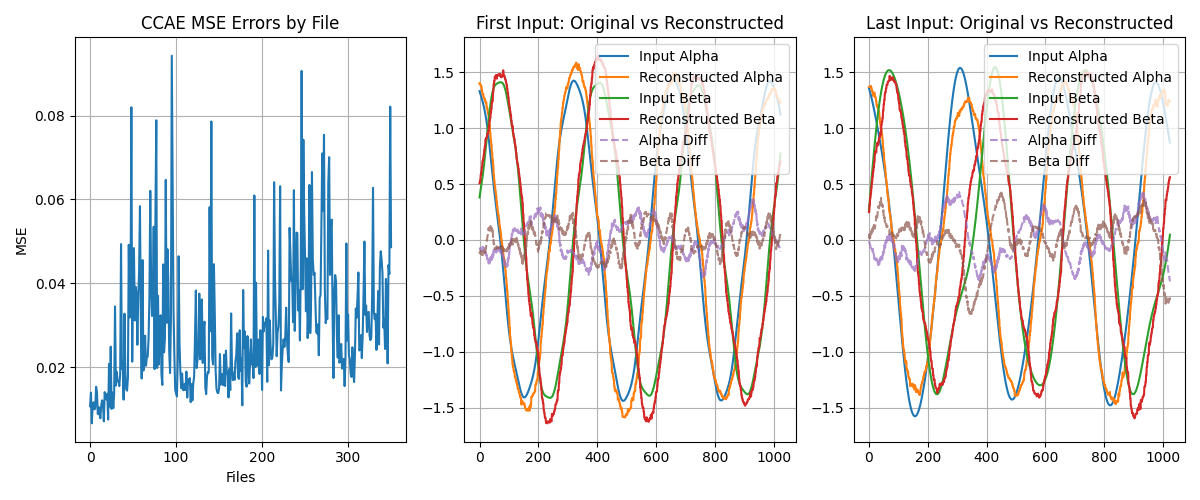

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12, 5))

# 1. MSE Errors by File
axs[0].plot(range(len(ccae_result['mse_avg_byfile'])), ccae_result['mse_avg_byfile'])
axs[0].set_title('CCAE MSE Errors by File')
axs[0].set_xlabel('Files')
axs[0].set_ylabel('MSE')
axs[0].grid(True)

# 2. First input: original vs reconstructed
first_input = all_inputs[0:1]
first_recon = my_ccae_model1_trained.predict([first_input[:, :, 0:1], first_input[:, :, 1:2], np.array([[1]])])
axs[1].plot(first_input[0, :, 0], label='Input Alpha')
axs[1].plot(np.squeeze(first_recon[0][0]), label='Reconstructed Alpha')
axs[1].plot(first_input[0, :, 1], label='Input Beta')
axs[1].plot(np.squeeze(first_recon[1][0]), label='Reconstructed Beta')
# 差異
axs[1].plot(first_input[0, :, 0] - np.squeeze(first_recon[0][0]), label='Alpha Diff', linestyle='--', alpha=0.7)
axs[1].plot(first_input[0, :, 1] - np.squeeze(first_recon[1][0]), label='Beta Diff', linestyle='--', alpha=0.7)
axs[1].set_title('First Input: Original vs Reconstructed')
axs[1].legend()
axs[1].grid(True)

# 3. Last input: original vs reconstructed
last_input = all_inputs[-1:]
last_recon = my_ccae_model1_trained.predict([last_input[:, :, 0:1], last_input[:, :, 1:2], np.array([[1]])])
axs[2].plot(last_input[0, :, 0], label='Input Alpha')
axs[2].plot(np.squeeze(last_recon[0][0]), label='Reconstructed Alpha')
axs[2].plot(last_input[0, :, 1], label='Input Beta')
axs[2].plot(np.squeeze(last_recon[1][0]), label='Reconstructed Beta')
# 差異
axs[2].plot(last_input[0, :, 0] - np.squeeze(last_recon[0][0]), label='Alpha Diff', linestyle='--', alpha=0.7)
axs[2].plot(last_input[0, :, 1] - np.squeeze(last_recon[1][0]), label='Beta Diff', linestyle='--', alpha=0.7)
axs[2].set_title('Last Input: Original vs Reconstructed')
axs[2].legend()
axs[2].grid(True)

# 統一第二、三張圖的 y 軸範圍
ymin = min(axs[1].get_ylim()[0], axs[2].get_ylim()[0])
ymax = max(axs[1].get_ylim()[1], axs[2].get_ylim()[1])
axs[1].set_ylim(ymin, ymax)
axs[2].set_ylim(ymin, ymax)

plt.tight_layout()
plt.show()

In [ ]:
print(model_input_signas)  # 檢查第一個檔案的結果形狀

NameError: name 'model_input_signas' is not defined

In [ ]:
# 根據 my_ccae_objects 的數量動態產生 (n, 1) 的 subplot
n = len(my_ccae_objects)
fig, axes = plt.subplots(n, 1, figsize=(12, 3 * n), sharex=True)

if n == 1:
    axes = [axes]  # 保證 axes 可迭代

for idx, (my_ccae, ax) in enumerate(zip(my_ccae_objects, axes)):
    ax.plot(my_ccae.basic_timelist["Time stamps"], my_ccae.ccae_repport["mse_avg_byfile"],
            label=f"File: {my_ccae.file_path.split(os.sep)[-1]}")
    ax.set_ylabel("MSE Error")
    ax.legend()
    ax.grid(True)
    ax.set_ylim(0, 0.005)

axes[-1].set_xlabel("Sample Index")
plt.tight_layout()
plt.show()

In [ ]:

# 繪製並重疊每次實驗的 MSE Errors
plt.figure(figsize=(12, 8))
plt.xlabel("Sample Index")
plt.ylabel("MSE Error")
for my_ccae in (my_ccae_objects):
    plt.plot(my_ccae.basic_timelist["Time stamps"],my_ccae.ccae_repport["mse_avg_byfile"],
             label=f"File: {my_ccae.file_path.split(os.sep)[-1]}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show(block=True)
plt.savefig("mse_errors_plot.png")
plt.ylim(0, 0.005)

In [ ]:
for my_ccae in (my_ccae_objects):
    plt.figure(figsize=(12, 8))
    plt.xlabel("Sample Index")
    plt.ylabel("MSE Error")
    plt.plot(my_ccae.basic_timelist["Time stamps"],my_ccae.ccae_repport["mse_avg_byfile"],
            label=f"File: {my_ccae.file_path.split(os.sep)[-1]}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show(block=True)